# Dataset Notebook

In this notebook, we outline the pipeline we followed for dataset exploration and the creation of all necessary functions to prepare it for model training. All the functions defined here have been collected in the file `dataset/utils.py` to make them available and usable in the experiments conducted in the file `Experiments.ipynb`.

## Envirnoment Setup

Here we install and import all the necessary libraries. We mount the drive and use the `cd` command to navigate to the project directory.

In [ ]:
!pip install filetype

In [ ]:
import os
import pathlib
import filetype
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Final_Project/'

/content/drive/.shortcut-targets-by-id/1wKqUB_Y6S42933NPubmLzrmazNFHNQsp/Final_Project


## Data loading

As the first step, we define a function to load the filenames and their corresponding label indices from the dataset directory. The directory has the following structure:

```plaintext
project_root/
├── dataset/
│   ├── covid19_dataset/
│   │   ├── covid/
│   │   │   ├── image1.jpg
│   │   │   └── image2.jpg
│   │   ├── normal/
│   │   │   ├── image1.jpg
│   │   │   └── image2.jpg
│   │   └── pneumonia/
│   │       ├── image1.jpg
│   │       └── image2.jpg


In [ ]:
def load_filenames(dataset_dir):
    '''Load the filenames and their corresponding label indices from a specified dataset directory.'''

    filenames = []
    label_idxs = []

    i = 0
    for lab in os.listdir(dataset_dir):
        current_dir = os.path.join(dataset_dir, lab)
        for img in os.listdir(current_dir):
            filenames.append(os.path.join(current_dir, img))
            label_idxs.append(i)
        i += 1

    print('Loading filenames completed.')

    return filenames, label_idxs


In [ ]:
dataset_dir = 'dataset/covid19_dataset'
class_names = ['covid', 'normal', 'pneumonia']
X, Y = load_filenames(dataset_dir)

Loading filenames completed.


## Handling Diverse Image Formats

We move on by analyzing the types of data using the `filetype` library to identify the formats of the images. This step is necessary since the images come from various sources and might be encoded in different formats. We create a list named `corrupted_images` for files whose format failed to be recognized, so we can remove them later.

In [ ]:
# Identify files with unrecognized formats
corrupted_images = np.array([True if filetype.guess(filename)==None else False for filename in X])
# Remove such files from the list
X_clean = list(np.array(X)[~corrupted_images])
# Check the formats of the images in the dataset
image_format = [filetype.guess(filename).extension for filename in X_clean]

print('Recognized Formats: ', np.unique(image_format))
print('\nN. of Images (before): ', len(X))
print('N. of Images (after) : ', len(X_clean))
print('N. of Corrupted Images: ', np.sum(corrupted_images))
print('\nCorrupted Images:')
for img in list(np.array(X)[corrupted_images]):
    print(img)

Recognized Formats:  ['bmp' 'jpg' 'png']

N. of Images (before):  2296
N. of Images (after) :  2282
N. of Corrupted Images:  14

Corrupted Images:
dataset/covid19_dataset/normal/00000463_000.png
dataset/covid19_dataset/normal/00000459_009.png
dataset/covid19_dataset/normal/00000459_057.png
dataset/covid19_dataset/normal/00000445_000.png
dataset/covid19_dataset/normal/00000461_001.png
dataset/covid19_dataset/normal/00000443_003.png
dataset/covid19_dataset/normal/00000443_002.png
dataset/covid19_dataset/normal/00000524_000.png
dataset/covid19_dataset/normal/00000521_000.png
dataset/covid19_dataset/normal/00000517_004.png
dataset/covid19_dataset/normal/00000510_000.png
dataset/covid19_dataset/normal/00000517_002.png
dataset/covid19_dataset/normal/00000520_000.png
dataset/covid19_dataset/normal/00000545_006.png


## Preprocessing

To ensure uniform input dimensions for the model, all images were resized to 224x224 pixels. Normalization was applied by dividing pixel values by 255. Additionally, to mitigate the impact of frequently embedded textual information in chest X-ray images, the top and bottom 8% of each image was cropped prior to training, as in Wang et al.

In [ ]:
def preprocess(image):
    '''Preprocess an image applying normalization, cropping and resizing'''

    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [224, 224])
    image = tf.image.crop_to_bounding_box(image, offset_height=int(224*0.1), offset_width=0, target_height=int(224*0.8), target_width=int(224))
    image = tf.image.resize(image, [224, 224])
    return image

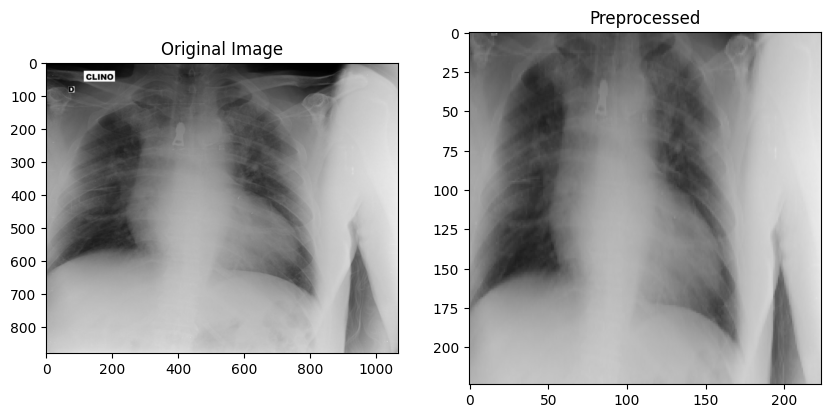

In [ ]:
img = tf.io.read_file(X[1018])
img = tf.io.decode_image(img, channels=3)
preprocessed_img = preprocess(img)

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(preprocessed_img)
ax[1].set_title('Preprocessed');

## Data Augmentation

To enhance the robustness of the deep neural network architectures tested, data augmentation techniques inspired by Wang et al. were employed, including:

- **Zoom**: `RandomZoom` zooms in or out on the image by up to ±15%.
- **Translation**: `RandomTranslation` shifts the image by up to ±10% in both the x and y directions.
- **Rotation**: `RandomRotation` rotates the image randomly within a range of ±10 degrees.
- **Horizontal Flip**: `RandomFlip` flips the image horizontally with a 50% chance.
- **Intensity Shift**: `RandomContrast` adjusts the contrast of the image by up to ±10%, simulating an intensity shift.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15, fill_mode='constant'),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='constant'),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(factor=0.1)
])

augmented_img = data_augmentation(preprocessed_img)

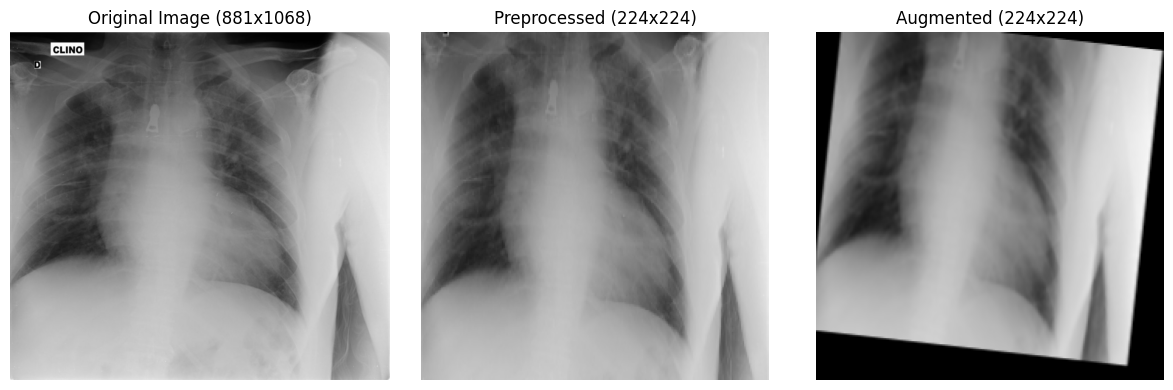

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(img, aspect='auto')
ax[0].set_title(f'Original Image ({img.shape[0]}x{img.shape[1]})')
ax[0].axis('off')

ax[1].imshow(preprocessed_img)
ax[1].set_title(f'Preprocessed ({preprocessed_img.shape[0]}x{preprocessed_img.shape[1]})')
ax[1].axis('off')

ax[2].imshow(augmented_img)
ax[2].set_title(f'Augmented ({augmented_img.shape[0]}x{augmented_img.shape[1]})')
ax[2].axis('off')

plt.tight_layout()
plt.savefig('./dataset/figures/preprocessing_and_augmentation.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## Dataset creation

The dataset creation pipeline incorporated several techniques to enhance model training efficiency and performance.
* `cache`: A caching system was employed after preprocessing to expedite access during training.
* `shuffle`: Shuffling was utilized to randomize the order of images, thus preventing the model from learning unintended biases.
* `batch`: Images were grouped into batches to allow for more efficient computation and gradient updates during training.
* `prefetch`: Prefetching was used to prepare data batches while the model was training on the current batch, reducing idle time and improving throughput.



In [ ]:
def get_label(file_path):
    '''Parse the label from the file path'''

    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    '''
    Decode the image and convert it into a Tensor using tf.io.decode_image.
    It supports multiple image formats including is a BMP, GIF, JPEG, and PNG.
    '''

    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3)
    # Ensure the image has shape [height, width, channels]
    img = tf.ensure_shape(img, [None, None, 3])

    return img

def load_image_with_label(file_path):
    '''Load an image and its label given the file path'''

    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def create_dataset(file_names, batch_size, shuffle, augment=True, cache_file=None):
    '''
    Constructs a TensorFlow Dataset object configured for image processing.

    This function prepares a dataset by loading images, applying preprocessing,
    and optionally augmenting, shuffling, batching, and prefetching the data.
    The dataset can be cached to speed up operations.
    '''

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(file_names)

    # Map the load_image function
    dataset = dataset.map(load_image_with_label, num_parallel_calls=tf.data.AUTOTUNE)

    # Map the preprocess function
    dataset = dataset.map(lambda x, y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Map the augment_image function
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(100)

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    print("Dataset correctly created.")

    return dataset

Create the dataset using the functions defined above.

In [ ]:
batch_size = 16
ds = create_dataset(X_clean,
                    batch_size=batch_size,
                    shuffle=True,
                    augment=True,
                    #cache_file='train_cache'
                    )

Dataset correctly created.


Plot some samples.

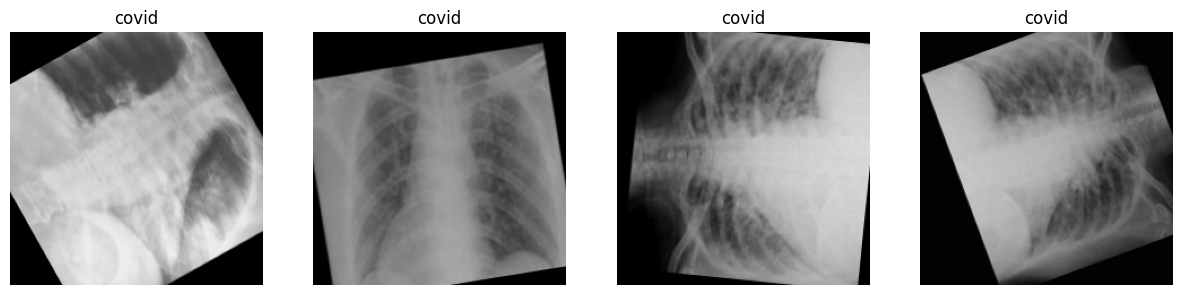

In [ ]:
image_batch, label_batch = next(iter(ds))

plt.figure(figsize=(15, 10))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")